# Gesture recognition

### Problem statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

* Thumbs up:  Increase the volume
* Thumbs down: Decrease the volume
* Left swipe: 'Jump' backwards 10 seconds
* Right swipe: 'Jump' forward 10 seconds  
* Stop: Pause the movie

In [53]:
import numpy as np
import os
import datetime
import os
import cv2
from imageio import imread

Setting the random seed so that the results don't vary drastically.

In [54]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow import keras 
tf.random.set_seed(30)

Reading the folders and setting the batch size

In [55]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [56]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Colab Notebooks/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Colab Notebooks/Project_data/val.csv').readlines())
batch_size = 10

# Generator
This is one of the most important part of the code.  Here we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames.

In [57]:
# Parameters initialization
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
total_frames = 30
nb_frames = 30  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

In [58]:
# Helper functions 

def func_normalize_data(data):
    return data/127.5-1

def func_get_random_affine():
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    I = np.float32([[1, 0, dx], [0, 1, dy]])
    return I

def func_init_batch_data(batch_size):
    batch_data = np.zeros((batch_size, nb_frames, nb_rows, nb_cols, nb_channel)) 
    batch_labels = np.zeros((batch_size,5)) 
    return batch_data, batch_labels

In [59]:
# def generator(source_path, folder_list, batch_size,validation=False):
#     print( 'Source path = ', source_path, '; batch size =', batch_size)
#     img_idx = [x for x in range(0, nb_frames)] 
#     while True:
#         t = np.random.permutation(folder_list)
#         num_batches = len(folder_list)//batch_size # calculate the number of batches
#         for batch in range(num_batches): # we iterate over the number of batches
#             batch_data,batch_labels = func_init_batch_data(batch_size);

#             # We will also build an augumented batch data with affine transformation
#             batch_data_aug,batch_labels_aug = func_init_batch_data(batch_size)

#             # We will also build an augmented batch data with horizontal flip
#             batch_data_flip,batch_labels_flip = func_init_batch_data(batch_size)

#             for folder in range(batch_size): # iterate over the batch_size
#                   imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]))  # read all the images in the folder
#                   M = func_get_random_affine() # Generate a random affine to be used in image transformation for buidling agumented data set
        
#                   for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                      image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
#                      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    
#                      #crop the images and resize them. Note that the images are of 2 different shape 
#                      if image.shape[0] != image.shape[1]:
#                            image=image[0:120,20:140]

#                      #and resizing the images
#                      resized = cv2.resize(image, (nb_rows,nb_cols), interpolation = cv2.INTER_AREA)
                  
#                      #Normal data
#                      batch_data[folder,idx] = (resized)
#                      M = func_get_random_affine()
#                      #Data with affine transformation
#                      batch_data_aug[folder,idx] = (cv2.warpAffine(resized, M, (resized.shape[0], resized.shape[1])))
#                      #Data with horizontal flip
#                      batch_data_flip[folder,idx]= np.flip(resized,1)

#                   batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#                   batch_labels_aug[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    
#                   batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#                   yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

#                   # Labeling data with horizobtal flip, right swipe becomes left swipe and viceversa
#                   if int(t[folder + (batch*batch_size)].strip().split(';')[2])==0:
#                       batch_labels_flip[folder, 1] = 1
#                   elif int(t[folder + (batch*batch_size)].strip().split(';')[2])==1:
#                       batch_labels_flip[folder, 0] = 1
#                   else:
#                       batch_labels_flip[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                  
    
#             batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
#             batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)

#             batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0) 
#             batch_labels_final = np.append(batch_labels_final, batch_labels_flip, axis = 0)
    
#             if validation:
#               batch_data_final=batch_data
#               batch_labels_final= batch_labels


# # Code for the remaining data points which are left after full batches
#     if (len(folder_list) != batch_size*num_batches):
#       batch_size = len(folder_list) - (batch_size*num_batches)
#       yield generator(source_path, folder_list, batch, batch_size, t,validation)


In [60]:
def generator(source_path, folder_list, batch_size, validation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,validation)
            
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,validation)


def load_batch_images(source_path, folder_list, batch_num, batch_size, t,validation):
    
    batch_data,batch_labels = func_init_batch_data(batch_size)
    
    # We will also build an augumented batch data with affine transformation
    batch_data_aug,batch_labels_aug = func_init_batch_data(batch_size)
    
    # We will also build an augmented batch data with horizontal flip
    batch_data_flip,batch_labels_flip = func_init_batch_data(batch_size)
    
    #create a list of image numbers you want to use for a particular video using full frames
    img_idx = [x for x in range(0, nb_frames)] 

    for folder in range(batch_size): # iterate over the batch_size
        # read all the images in the folder
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
        # Generate a random affine to be used in image transformation for buidling agumented data set
        M = func_get_random_affine()
        
        #  Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx): 
            ## image = imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Cropping non symmetric frames
            if image.shape[0] != image.shape[1]:
                image=image[0:120,20:140]
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes   
            resized = cv2.resize(image, (nb_rows,nb_cols), interpolation = cv2.INTER_AREA)
            #Normal data
            batch_data[folder,idx] = (resized)
            
            #Data with affine transformation
            batch_data_aug[folder,idx] = (cv2.warpAffine(resized, M, (resized.shape[0], resized.shape[1])))
            
            # Data with horizontal flip
            batch_data_flip[folder,idx]= np.flip(resized,1)

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        # Labeling data with horizobtal flip, right swipe becomes left swipe and viceversa
        if int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
        elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                    
        else:
                    batch_labels_flip[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
                  
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
    batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)

    batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0) 
    batch_labels_final = np.append(batch_labels_final, batch_labels_flip, axis = 0)
    
    if validation:
        batch_data_final=batch_data
        batch_labels_final= batch_labels
        
    return batch_data_final,batch_labels_final


In [61]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/Colab Notebooks/Project_data/train'
val_path = '/content/gdrive/MyDrive/Colab Notebooks/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


# Model


In [62]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

Plotting Code

In [63]:
import matplotlib.pyplot as plt


def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

Model 1

In [64]:
filters = [8,16,32,64]
dense = [256, 128, 5]

# Input
input_shape=(nb_frames,nb_rows,nb_cols,nb_channel)

# Define model
model = Sequential()

model.add(Conv3D(filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(dense[2], activation='softmax'))

In [65]:
from tensorflow.keras.optimizers import Adam
optimiser = Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_9 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_12 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 15, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_15 (Conv3D)          (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_10 (Bat  (None, 15, 60, 60, 16)  

In [66]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [67]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [68]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [69]:
batch_size = 10
num_epochs = 20
model_1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Project_data/train ; batch size = 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.7378 - categorical_accuracy: 0.2826  Source path =  /content/gdrive/MyDrive/Colab Notebooks/Project_data/val ; batch size = 10

Epoch 1: saving model to model_init_2022-09-1218_44_14.800875/model-00001-1.73784-0.28255-2.05832-0.23000.h5
67/67 [==============================] - 6589s 100s/step - loss: 1.7378 - categorical_accuracy: 0.2826 - val_loss: 2.0583 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.5413 - categorical_accuracy: 0.3449
Epoch 2: saving model to model_init_2022-09-1218_44_14.800875/model-00002-1.54127-0.34494-1.30391-0.44000.h5
67/67 [==============================] - 44s 665ms/step - loss: 1.5413 - categorical_accuracy: 0.3449 - val_loss: 1.3039 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.4819 - categorical_accuracy: 0.3632
Epoch 3: saving model to model_in

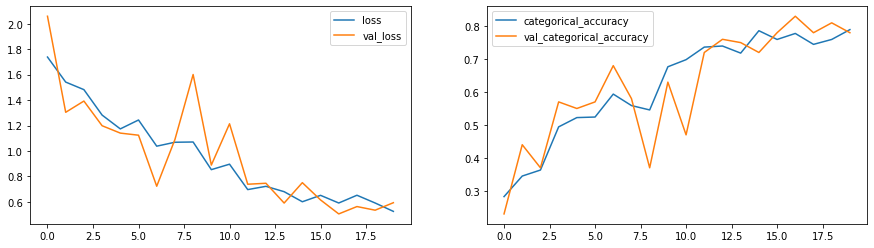

In [70]:
plot(model_1)

Model 2

In [71]:
batch_size = 20
num_epochs = 20

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.5303 - categorical_accuracy: 0.7908
Epoch 1: saving model to model_init_2022-09-1218_44_14.800875/model-00001-0.53035-0.79085-0.54789-0.80000.h5
34/34 [==============================] - 22s 664ms/step - loss: 0.5303 - categorical_accuracy: 0.7908 - val_loss: 0.5479 - val_categorical_accuracy: 0.8000 - lr: 3.1250e-05
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.6562 - categorical_accuracy: 0.7320
Epoch 2: saving model to model_init_2022-09-1218_44_14.800875/model-00002-0.65624-0.73203-0.49537-0.82000.h5
34/34 [==============================] - 24s 723ms/step - loss: 0.6562 - categorical_accuracy: 0.7320 - val_loss: 0.4954 - val_categorical_accuracy: 0.8200 - lr: 3.1250e-05
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.5071 - categorical_accuracy: 0.8137
Epoch 3: saving model to model_init_2022-09-1218_44_14.800875/model-00003-0.50708-0.81373-0.62171-0.84000.h5
34/34 [==

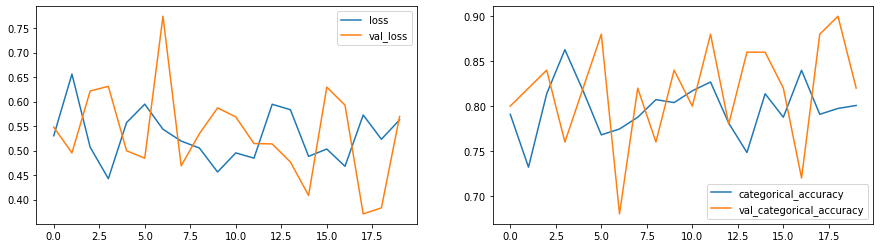

In [72]:
plot(model_2)

**Model 3**


In [73]:
batch_size = 30
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 0.5310 - categorical_accuracy: 0.8068
Epoch 1: saving model to model_init_2022-09-1218_44_14.800875/model-00001-0.53100-0.80676-0.64043-0.80000.h5
23/23 [==============================] - 16s 720ms/step - loss: 0.5310 - categorical_accuracy: 0.8068 - val_loss: 0.6404 - val_categorical_accuracy: 0.8000 - lr: 4.8828e-07
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.4871 - categorical_accuracy: 0.8164
Epoch 2: saving model to model_init_2022-09-1218_44_14.800875/model-00002-0.48710-0.81643-0.47657-0.80000.h5
23/23 [==============================] - 16s 733ms/step - loss: 0.4871 - categorical_accuracy: 0.8164 - val_loss: 0.4766 - val_categorical_accuracy: 0.8000 - lr: 4.8828e-07
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.5198 - categorical_accuracy: 0.7826
Epoch 3: saving model to model_init_2022-09-1218_44_14.800875/model-00003-0.51981-0.78261-0.74782-0.77500.h5
23/23 [==

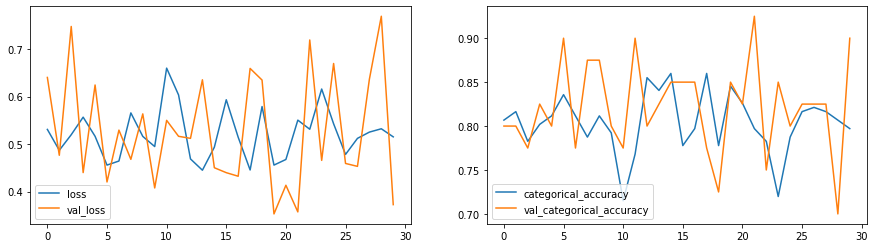

In [74]:
plot(model_3)

**Final Model**


In [75]:
batch_size = 50
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.3692 - categorical_accuracy: 0.8810
Epoch 1: saving model to model_init_2022-09-1218_44_14.800875/model-00001-0.36924-0.88095-0.63536-0.75000.h5
14/14 [==============================] - 11s 806ms/step - loss: 0.3692 - categorical_accuracy: 0.8810 - val_loss: 0.6354 - val_categorical_accuracy: 0.7500 - lr: 4.7684e-10
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.5342 - categorical_accuracy: 0.7619
Epoch 2: saving model to model_init_2022-09-1218_44_14.800875/model-00002-0.53422-0.76190-0.36991-0.95000.h5
14/14 [==============================] - 10s 744ms/step - loss: 0.5342 - categorical_accuracy: 0.7619 - val_loss: 0.3699 - val_categorical_accuracy: 0.9500 - lr: 4.7684e-10
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.5096 - categorical_accuracy: 0.8095
Epoch 3: saving model to model_init_2022-09-1218_44_14.800875/model-00003-0.50956-0.80952-0.89204-0.75000.h5
14/14 [==

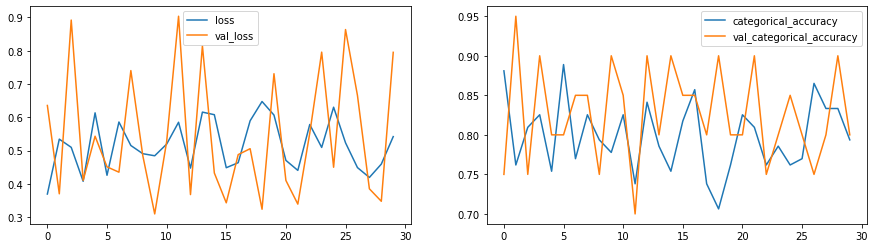

In [76]:
plot(model_4)